In [1]:
%matplotlib notebook

import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
from trajectories import simulate, simulate_rotation, get_view_vector, std_from_r, trajectory, simulate_c
from metric import rmse

In [3]:
import seetree

In [4]:
radius = 2

In [ ]:
views = []
positions = []
for angle in angles:
    pos = simulate(angle, radius)
    rot = simulate_rotation(angle, radius)
    view = get_view_vector(rot, pos)
    views.append(view)
    positions.append(pos)
positions = np.array(positions)
views = np.array(views)

In [ ]:
orig = []
for i in range(360):
    pos = trajectory(i, radius)
    orig.append(pos)
orig = np.array(orig)

In [ ]:
# filtered = np.array(filtered)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(filtered[:, 0], filtered[:, 1], filtered[:, 2])
ax.scatter(orig[:, 0], orig[:, 1], orig[:, 2])
ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2])
ax.scatter(positions2[:, 0], positions2[:, 1], positions2[:, 2])

In [ ]:
# views = []
positions2 = []
for angle in angles:
    pos = simulate_c(angle, radius, base_std=0.5)
#     rot = simulate_rotation(angle, radius)
#     view = get_view_vector(rot, pos)
#     views.append(view)
    positions2.append(pos)
positions2 = np.array(positions2)
# views = np.array(views)

In [ ]:
final = (positions / 0.001 + positions2 / 0.5) / (1/0.001 + 1 / 0.5)

<IPython.core.display.Javascript object>


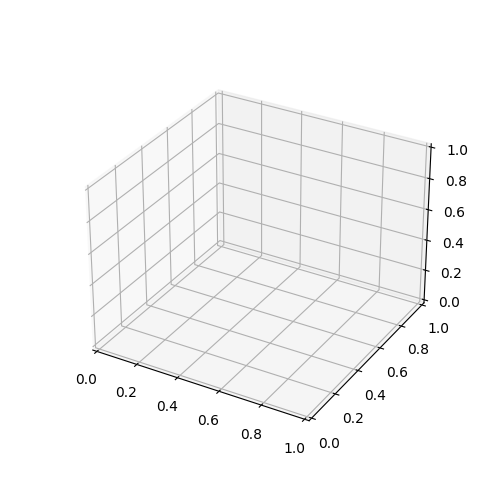

NameError: name 'orig' is not defined

In [9]:
# filtered = np.array(filtered)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(filtered[:, 0], filtered[:, 1], filtered[:, 2])
ax.scatter(orig[:, 0], orig[:, 1], orig[:, 2])
ax.scatter(final[:, 0], final[:, 1], final[:, 2])
# ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2])
# ax.scatter(positions2[:, 0], positions2[:, 1], positions2[:, 2])

In [ ]:
rmse(orig, final)

In [ ]:
rmse(orig, positions)

In [ ]:
rmse(orig, positions2)

# Kalman Filter

In [6]:
import numpy as np
from filterpy.kalman import KalmanFilter, UnscentedKalmanFilter, ExtendedKalmanFilter
# from KalmanFilter import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import pickle

In [7]:
def np_from_traj(trajectory):
    positions = []
    rotations = []
    for item in trajectory.collection:
        positions.append(item.T)
        rotations.append(item.Re)
    return np.array(positions), np.array(rotations)

In [8]:
with open('data/zed_trajectory.pkl', 'rb') as f:
    zed_data = pickle.load(f)

with open('data/gt_trajectory.pkl', 'rb') as f:
    gt_data = pickle.load(f)

with open('data/ms_trajectory.pkl', 'rb') as f:
    ms_data = pickle.load(f)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [11]:
gt_traj, gt_rot = np_from_traj(gt_data)
zed_traj, zed_rot = np_from_traj(zed_data)
ms_traj, ms_rot = np_from_traj(ms_data)


In [ ]:
ms_traj.shape

In [ ]:
my_filter = KalmanFilter(dim_x=6, dim_z=3)

In [24]:
my_filter = KalmanFilter(dim_x=6, dim_z=3)
dt = 1
my_filter.x = [ms_traj[0][0], ms_traj[0][1], ms_traj[0][2], 0., 0., 0.]
# my_filter.x = [0., 0., 0., 0., 0., 0.]

# x, y, z, x', y', z',
my_filter.F = np.array([[1., 0, 0., dt, 0, 0],
                        [0., 1., 0, 0, dt, 0],
                        [0., 0., 1., 0., 0, dt],
                        [0., 0., 0., 1., 0., 0],
                        [0., 0., 0., 0., 1., 0],
                        [0., 0., 0, 0, 0, 1.]
                        ])    # state transition matrix

my_filter.H = np.array([
    [1., 0., 0., 0, 0, 0],
    [0., 1., 0., 0, 0, 0],
    [0., 0., 1., 0, 0, 0],
])    # Measurement function
# my_filter.P                  # covariance matrix
my_filter.R = 0.01#std_from_r(0.001, radius)                      # state uncertainty
my_filter.Q = Q_discrete_white_noise(3, dt, 10, 2) # process uncertainty


In [29]:
filtered = []
for i in range(1, len(ms_traj)):
    my_filter.predict()
    my_filter.update(zed_traj[i])
    my_filter.update(ms_traj[i])
    
    x = my_filter.x
    filtered.append(x)
filtered = np.array(filtered)

In [30]:
filtered.shape

(3599, 6)

<IPython.core.display.Javascript object>


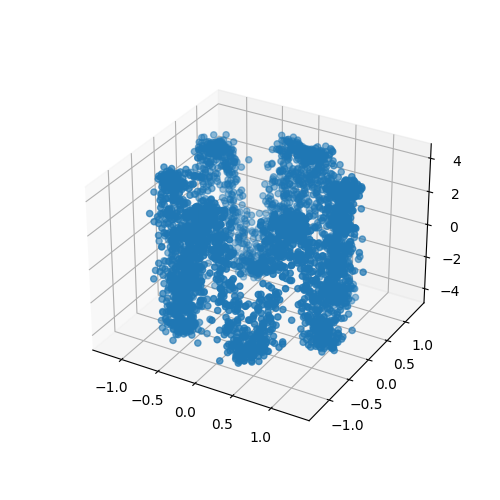

In [14]:
# filtered = np.array(filtered)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(filtered[:, 0], filtered[:, 1], filtered[:, 2])
# ax.scatter(gt_traj[:, 0], gt_traj[:, 1], gt_traj[:, 2])
ax.scatter(zed_traj[:, 0], zed_traj[:, 1], zed_traj[:, 2])
# ax.scatter(ms_traj[:, 0], ms_traj[:, 1], ms_traj[:, 2])

# ax.scatter(final[:, 0], final[:, 1], final[:, 2])
# ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2])
# ax.scatter(positions2[:, 0], positions2[:, 1], positions2[:, 2])

In [32]:
rmse(gt_traj[1:], filtered[:, :3])

(array([0.05066856, 0.0905944 , 0.09078975]), 0.07735090204617308)

In [33]:
rmse(gt_traj[1:], ms_traj[1:])

(array([0.0795678 , 0.07854898, 0.07852454]), 0.07888043729059428)

In [34]:
rmse(gt_traj[1:], zed_traj[1:])

(array([0.07889183, 0.07832407, 0.08204055]), 0.07975215076858505)

# Acceleration

In [42]:
my_filter = KalmanFilter(dim_x=9, dim_z=3)
dt = 1
my_filter.x = [ms_traj[0][0], ms_traj[0][1], ms_traj[0][2], 0., 0., 0., 0., 0., 0.]
# my_filter.x = [0., 0., 0., 0., 0., 0.]

# x, y, z, x', y', z',
my_filter.F = np.array([[1., 0., 0., dt, 0., 0., dt**2 / 2, 0., 0.],
                        [0., 1., 0., 0., dt, 0., 0., dt**2 / 2, 0.],
                        [0., 0., 1., 0., 0., dt, 0., 0., dt**2 / 2],
                        [0., 0., 0., 1., 0., 0., dt, 0., 0.],
                        [0., 0., 0., 0., 1., 0., 0., dt, 0.],
                        [0., 0., 0., 0., 0., 1., 0., 0., dt],
                        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
                        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
                        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
                        ])    # state transition matrix

my_filter.H = np.array([
    [1., 0., 0., 0, 0, 0, 0, 0, 0],
    [0., 1., 0., 0, 0, 0, 0, 0, 0],
    [0., 0., 1., 0, 0, 0, 0, 0, 0],
])    # Measurement function
# my_filter.P                  # covariance matrix
my_filter.R = 0.001#std_from_r(0.001, radius)                      # state uncertainty
my_filter.Q = Q_discrete_white_noise(3, dt, 0.1, 3) # process uncertainty


In [43]:
filtered = []
for i in range(1, len(ms_traj)):
    my_filter.predict()
    my_filter.update(zed_traj[i])
    my_filter.update(ms_traj[i])
    
    x = my_filter.x
    filtered.append(x)
filtered = np.array(filtered)

In [44]:
rmse(gt_traj[1:], filtered[:, :3])

(array([0.05081016, 0.09019214, 0.09040616]), 0.07713615596299274)

In [45]:
rmse(gt_traj[1:], ms_traj[1:])

(array([0.0795678 , 0.07854898, 0.07852454]), 0.07888043729059428)

In [39]:
gt_traj[:, 0]

array([ 0.00062838,  0.00377028,  0.00691214, ..., -0.0031419 ,
       -0.00251352, -0.00188514])

In [40]:
plt.plot(np.arange(3600), gt_traj[:, 2])